In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cmath
import math
from scipy import io, stats

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
fig_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/manuscript'
filename = 'vars-pa29dir4A-pre500-post300.mat'
dt = 50

In [2]:
data = io.loadmat(data_folder+'vars/'+filename)

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vels         =  data['vels'] # x and y eye velocities
acc          =  data['acc'] # x and y eye accelerations
conditions   =  data['contConditions']

out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

#cond_binned = bin_output(conditions,out_times,dt,out_times[0],out_times[-1],1)

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])

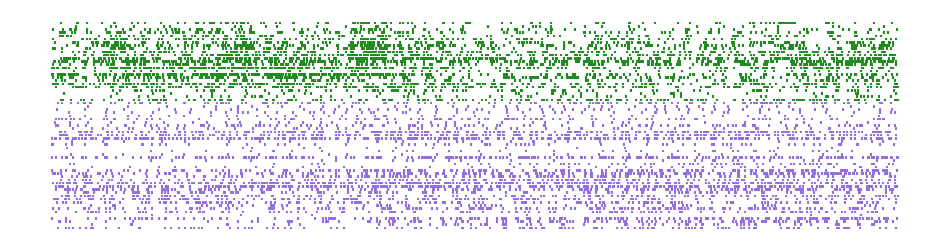

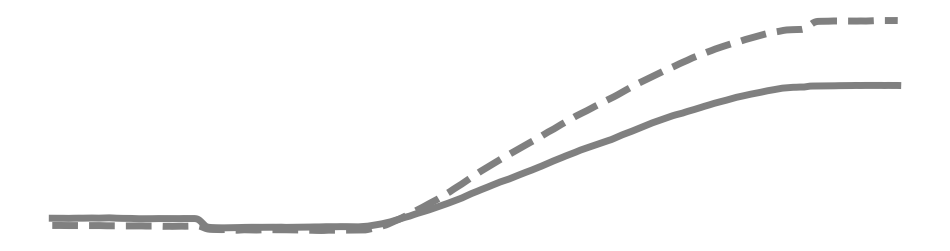

In [14]:
trial = [644] #657(55),624(145),644*(235),623(325),

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
poses = pos[np.isin(conditions[:,0],trial)]

# FIGURES
fig, ax = plt.subplots(figsize=(12, 3))

ax.eventplot(spikes[:40], colors='mediumpurple', linelengths=0.8, lineoffsets=np.arange(40));
ax.eventplot(spikes[40:], colors='forestgreen', linelengths=0.8, lineoffsets=np.arange(40,len(spikes)));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(-1*poses[:,0], label='HE', color='gray', linestyle='-', linewidth=5)
ax.plot(-1*poses[:,1], label='VE', color='gray', linestyle='--', linewidth=5)

#plt.legend()

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')